In [1]:
import h5py
import glob
import bisect
import distribution
import numpy as np
import matplotlib.pyplot as plt


def newest_output(path):
    list2 = glob.glob(path + 'output_??_.h5')
    if len(list2) > 0:
        return max( glob.glob(path + 'output_??_.h5'))
    else:
        return max( glob.glob(path + 'output_?_.h5'))

folder = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/2018_lowres_diff30/"

fnames = []
try:
    newest = newest_output(folder)
    numoffiles = int(newest.split("_")[-2])
except:
    print("Finding newest output unsuccesful")
    
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    fnames.append(fname)
    
def calculate_indices(timegrid, start, ms_step):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames
    
def calculate_indices2(timegrid, start, number):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    ms_step = (timegrid[-1] - timegrid[i]) / number
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames

In [2]:
concat = distribution.Distribution(fnames)

In [3]:
endtime = '{0:.0f}'.format(concat.timegrid_ms[-1])
print(str(endtime) + " ms")
output_file = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/ndc2_30_distribution.h5"
hf = h5py.File(output_file, 'w')

510 ms


In [4]:
keylist = ["dr", "real_volumes_of_cells", "major_radius", "minor_radius", "radialgrid", "radialgrid_edges",
           "re_energygrid_MeV"]
for key in keylist:
    hf.create_dataset(key, data=concat.__dict__[key])
    
frames = calculate_indices(concat.timegrid_ms, 0, 1)
re_density_sparse = concat.f_re_avg_density[frames, :, :]
n_tot_sparse = concat.n_tot[frames, :]
n_re_sparse = concat.n_re [frames, :]
timegrid_sparse = concat.timegrid_ms[frames]

hf.create_dataset("dn_over_dEdr", data=re_density_sparse)
hf.create_dataset("timegrid_ms", data=timegrid_sparse)
hf.create_dataset("n_tot", data=n_tot_sparse)
hf.create_dataset("n_re", data=n_re_sparse)
hf.close()

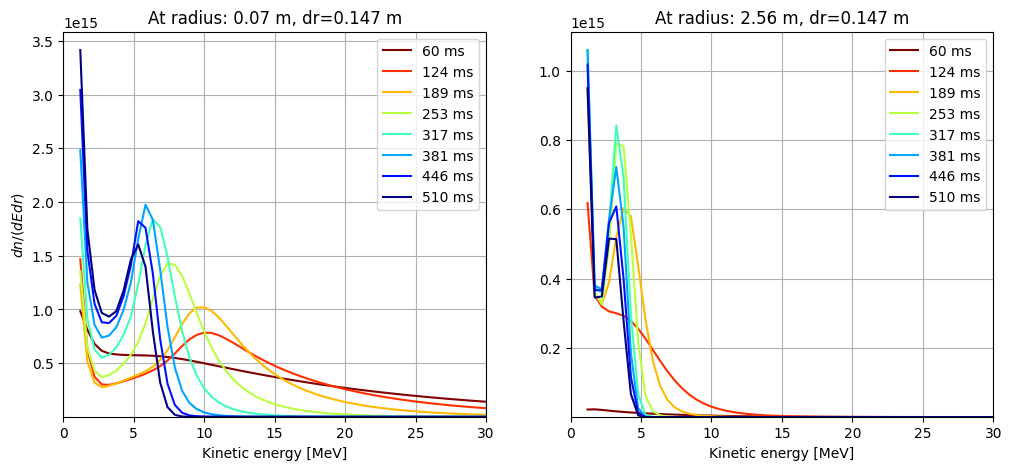

In [5]:
hf = h5py.File(output_file, 'r')
timegrid = hf["timegrid_ms"][()]
radialgrid = hf["radialgrid"][()]
dr = hf["dr"][()]

# Change the radial cell here from 0 to 19
radial_cell_1 = 0
radial_cell_2 = 17

if True:
    indices = calculate_indices2(timegrid, 60, 7)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = hf["re_energygrid_MeV"][()]
    ydata = hf["dn_over_dEdr"][()]
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell_1, :], label='{0:.0f}'.format(np.round(timegrid[i], 0))+" ms", 
                 color=ccolors[j])
        j += 1

    plt.ylabel(r'$dn/(dEdr)$')
    plt.xlabel(r'Kinetic energy [MeV]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell_1]) + " m, dr="
              + '{0:.3f}'.format(dr[radial_cell_1]) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e12, None)
    plt.xlim(0, 30)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    

    indices = calculate_indices2(timegrid, 60, 7)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = hf["re_energygrid_MeV"][()]
    ydata = hf["dn_over_dEdr"][()]
    #fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 2)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell_2, :], label='{0:.0f}'.format(np.round(timegrid[i], 0))+" ms", 
                 color=ccolors[j])
        j += 1

    #plt.ylabel(r'$dn/(dEdr)$')
    plt.xlabel(r'Kinetic energy [MeV]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell_2]) + " m, dr="
              + '{0:.3f}'.format(dr[radial_cell_2]) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e12, None)
    plt.xlim(0, 30)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    
hf.close()

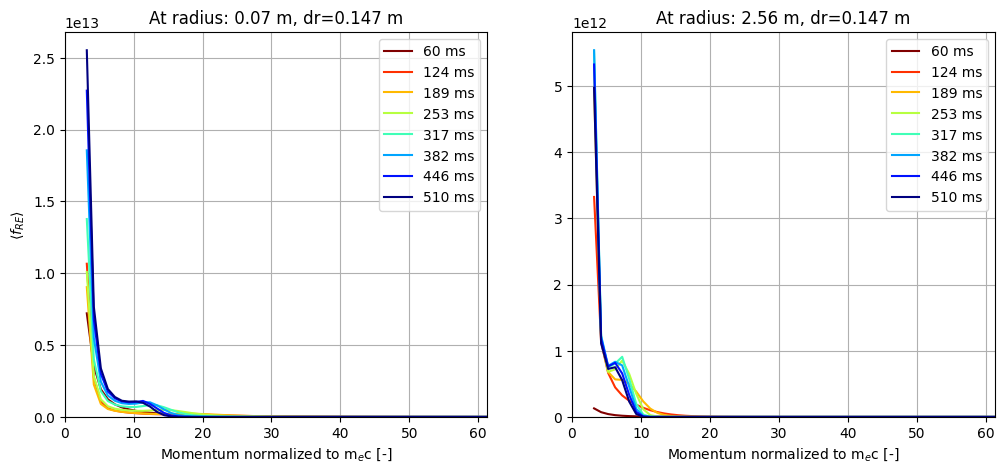

In [17]:
hf = h5py.File(output_file, 'r')
timegrid = concat.timegrid_ms
radialgrid = concat.radialgrid
dr = hf["dr"][()]

# Change the radial cell here from 0 to 19
radial_cell_1 = 0
radial_cell_2 = 17

if True:
    indices = calculate_indices2(timegrid, 60, 7)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.re_momentumgrid
    ydata = concat.f_re_avg
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell_1, :], label='{0:.0f}'.format(np.round(timegrid[i], 0))+" ms", 
                 color=ccolors[j])
        j += 1

    plt.ylabel(r'$\langle f_{RE}\rangle$')
    plt.xlabel(r'Momentum normalized to m$_e$c [-]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell_1]) + " m, dr="
              + '{0:.3f}'.format(dr[radial_cell_1]) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, None)
    plt.xlim(0, 61.32)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    

    indices = calculate_indices2(timegrid, 60, 7)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.re_momentumgrid
    ydata = concat.f_re_avg
    #fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 2)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell_2, :], label='{0:.0f}'.format(np.round(timegrid[i], 0))+" ms", 
                 color=ccolors[j])
        j += 1

    #plt.ylabel(r'$dn/(dEdr)$')
    plt.xlabel(r'Momentum normalized to m$_e$c [-]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell_2]) + " m, dr="
              + '{0:.3f}'.format(dr[radial_cell_2]) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, None)
    plt.xlim(0, 61.32)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    
hf.close()

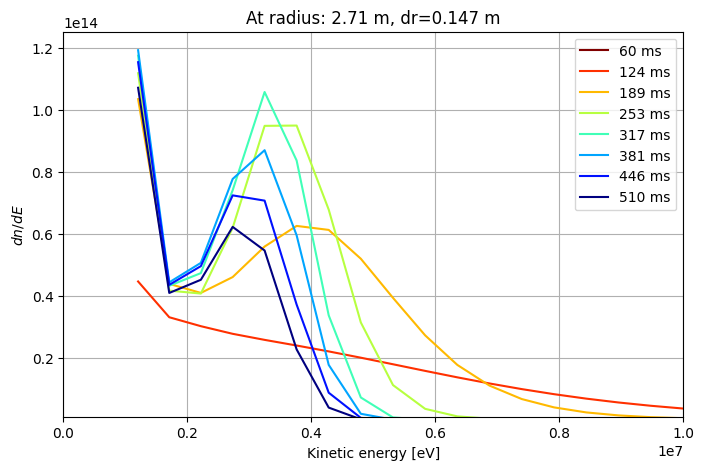

In [32]:
hf = h5py.File(output_file, 'r')
timegrid = hf["timegrid"][()]
radialgrid = hf["radialgrid"][()]
dr = hf["dr"][()]
if True:
    indices = calculate_indices2(timegrid * 1000, 60, 7)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))
    radial_cell = 18

    xdata = hf["re_energygrid_eV"][()]
    ydata = hf["dn_over_dEdr"][()]
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell, :] * dr[radial_cell],
                 label='{0:.0f}'.format(np.round(timegrid[i] * 1000, 0))+" ms", 
                 color=ccolors[j])
        j += 1

    plt.ylabel(r'$dn/dE$')
    plt.xlabel(r'Kinetic energy [eV]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell]) + " m, dr="
              + '{0:.3f}'.format(dr[radial_cell]) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e12, None)
    plt.xlim(0, 1e7)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    
hf.close()

In [33]:
hf.close()